# 필요한 라이브러리 import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
plt.rc('font',family='Malgun Gothic')
plt.rc('font',size=10)
from sklearn.metrics import mean_absolute_error
import pickle
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer,StandardScaler,PowerTransformer,MinMaxScaler
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from itertools import combinations
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import KFold
import tensorflow as tf
warnings.filterwarnings(action='ignore')

# 데이터로드

In [2]:
# 빈 데이터 프레임 생성

fm_data_df = pd.DataFrame(columns=['이름','포지션','골','도움','경기당 팀 득점/90',
                                 '경기당 팀 실점/90', 'Cr C/A', 'FA', '반칙 수/90', '기회 창출/90',
                                 '경기당 유효 슈팅/90', '경기당 슈팅/90', 'Int/90', '달린 거리/90분', 
                                 '공중 A/90', '태클 성공률','경기당 패스 시도/90', '경기당 패스 성공/90', 
                                 'K Ps/90', '태클 성공/90', '드리블 성공/90', 
                                 '헤더 성공/90', 'Cr A/90', '평균획득승점/경기'])

# 모든 데이터 프레임 이어붙이기
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2021-2022/2021-2022ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2022-2023/2022-2023ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2023-2024/2023-2024ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)

# 데이터 프레임 컬럼명 변경 및 자료형 변경
fm_data_df.rename(columns={'Cr C/A':'크로스 성공률','FA':'파울 획득','Int/90':'인터셉트/90','공중 A/90':'공중볼시도/90','K Ps/90':'키패스/90','Cr A/90':'크로스 시도/90'},inplace=True)
fm_data_df = fm_data_df.astype({'골':np.int64,'도움':np.int64,'파울 획득':np.int64,'태클 성공률':np.int64})

# 공격수만 추출
defender_df = fm_data_df[fm_data_df['포지션']=='수비수']

# 수비수 EDA

In [3]:
# 데이터 분석에 필요한 변수만 추출

num_col = [defender_df.columns[i] for i,x in enumerate(defender_df.dtypes) if x == 'int64' or x == 'float64']
features = list(set(num_col) - set(['평균획득승점/경기','출장시간','승','무','패','경기당 팀 득점/90','경기당 팀 실점/90']))
target = ['평균획득승점/경기']

## 이상치 확인

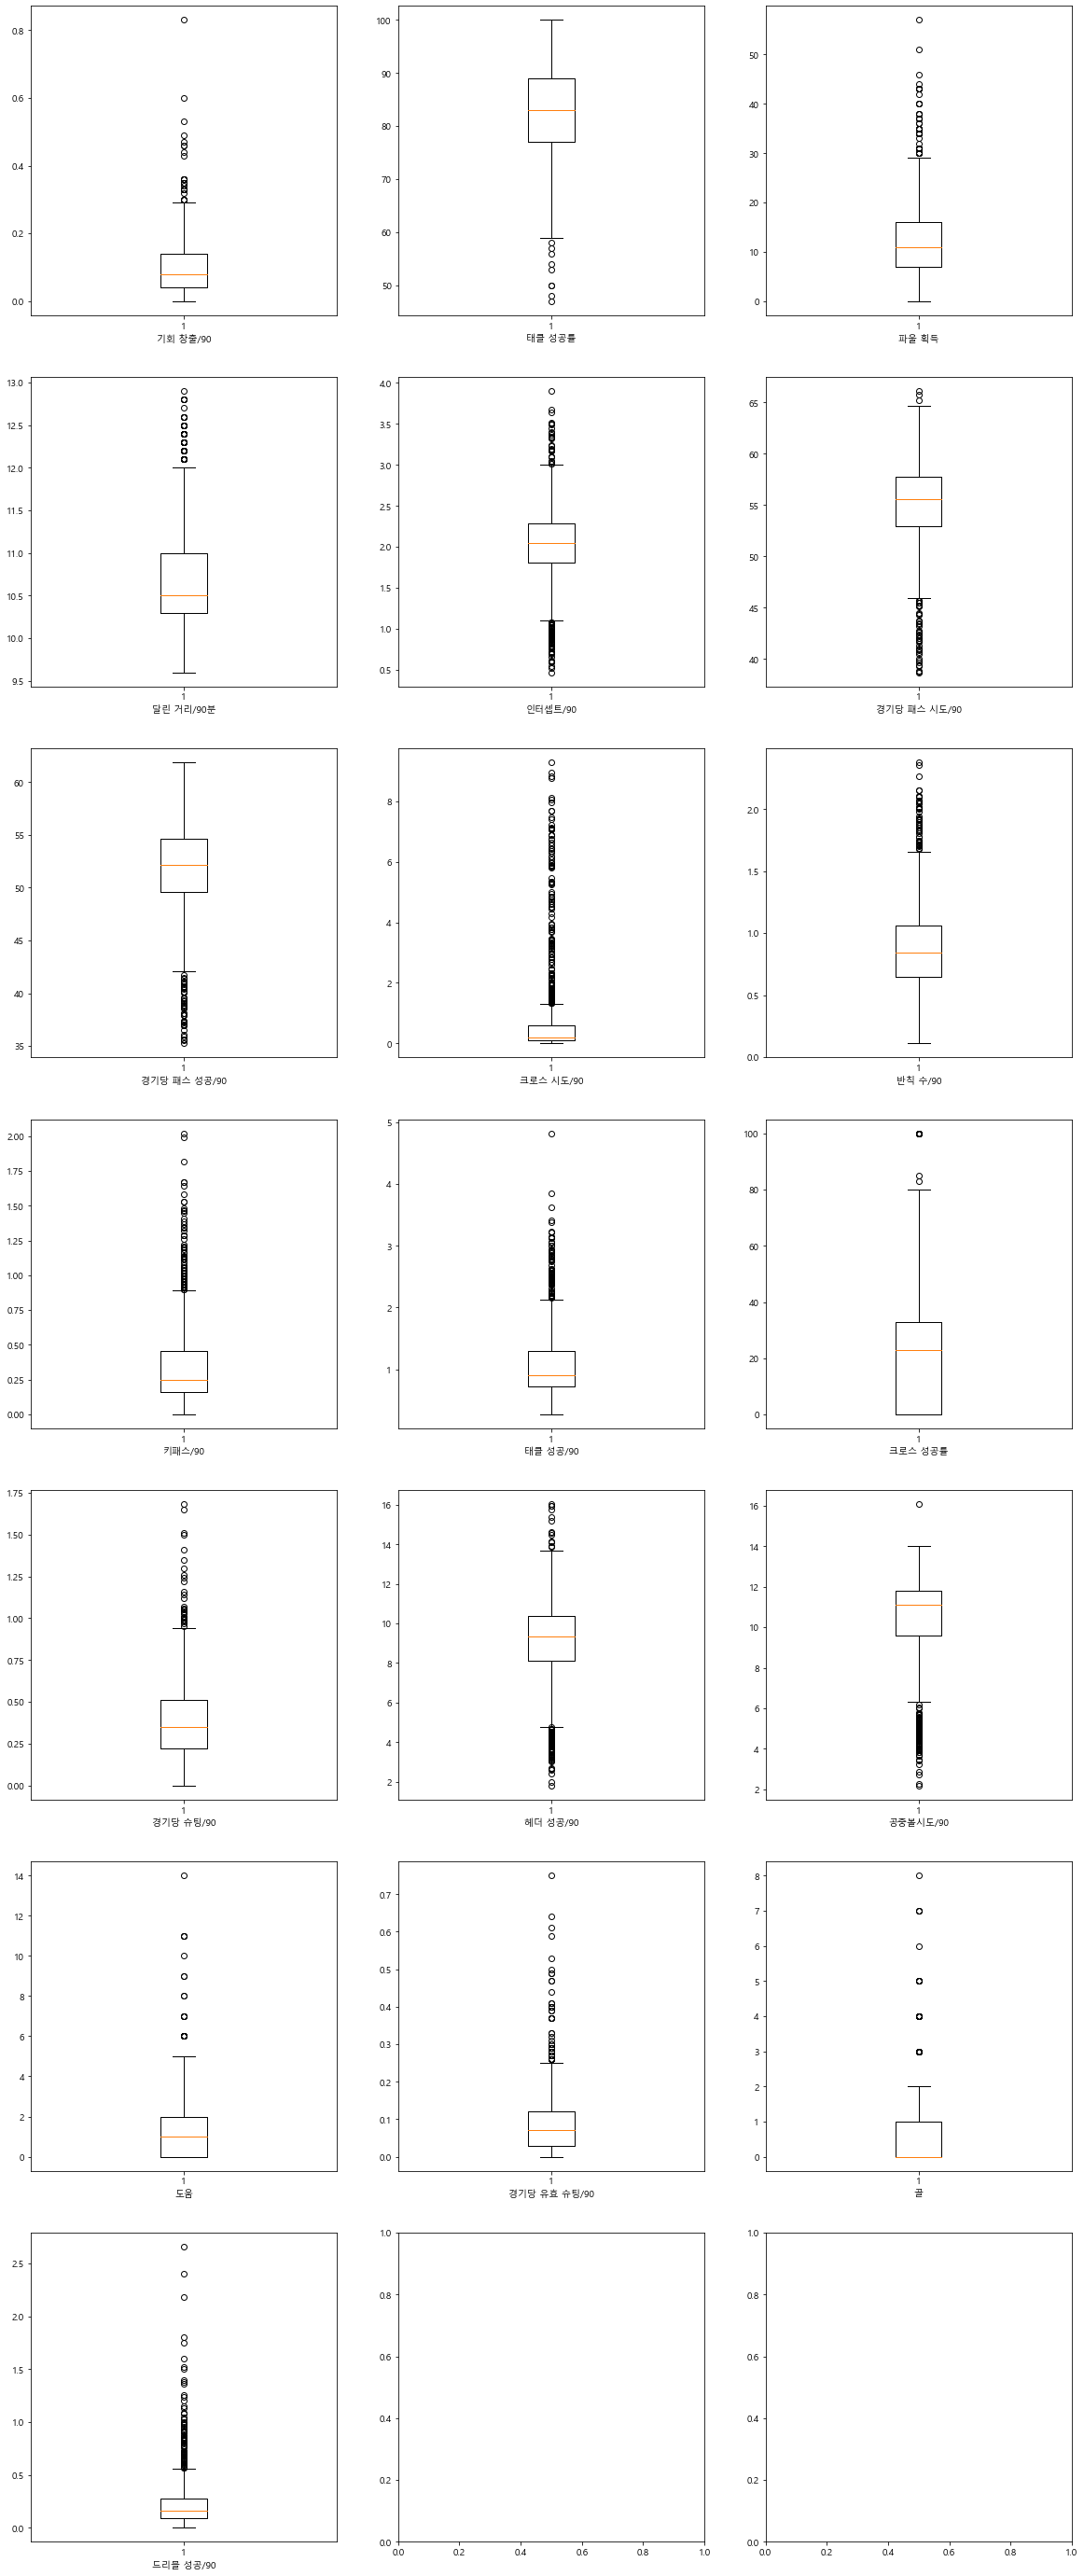

In [5]:
# 모든 변수의 Box plot 시각화

fig , axes = plt.subplots(7,3,figsize=(20,50))

for i, (ax,feature) in enumerate(zip(axes.ravel(),features)) :
    ax.set_xlabel(feature)
    ax.boxplot(defender_df.loc[:,feature])
    
plt.show()

In [6]:
# 데이터 당 이상치의 비율을 구하기
# 데이터는 990개인데 이상치가 그다지 많지 않다.
# 그래서 이상치의 비율이 5%가 넘는 변수만 tranformer를 적용한다.

out_ratio = defaultdict(float)

order_feature = ['골','도움']

for feature in set(features)-set(order_feature):
    
    data = defender_df[feature].to_numpy()   
    Q1 = np.quantile(data,0.25)
    Q3 = np.quantile(data,0.7)
    low_bound = Q1 - 1.5 * (Q3-Q1)
    high_bound = Q3 + 1.5 * (Q3-Q1)
    out_ratio[feature] = (len(data[data>high_bound]) + len(data[data>=high_bound])) / len(data)

print(sorted(out_ratio.items(),key=lambda x : x[1],reverse=True))    
    
outlier_features = [k for k,v in out_ratio.items() if v > 0.05]
nonoutlier_features = list((set(features) - set(outlier_features)) -set(order_feature))

[('크로스 시도/90', 0.3515695067264574), ('달린 거리/90분', 0.32466367713004485), ('키패스/90', 0.3040358744394619), ('태클 성공/90', 0.21524663677130046), ('드리블 성공/90', 0.19103139013452916), ('반칙 수/90', 0.12645739910313902), ('파울 획득', 0.11300448430493273), ('경기당 유효 슈팅/90', 0.11121076233183856), ('기회 창출/90', 0.10224215246636771), ('경기당 슈팅/90', 0.09147982062780269), ('인터셉트/90', 0.07713004484304933), ('크로스 성공률', 0.06995515695067264), ('헤더 성공/90', 0.03766816143497758), ('경기당 패스 시도/90', 0.016143497757847534), ('경기당 패스 성공/90', 0.0053811659192825115), ('공중볼시도/90', 0.0017937219730941704), ('태클 성공률', 0.0)]


## 선형성 검정

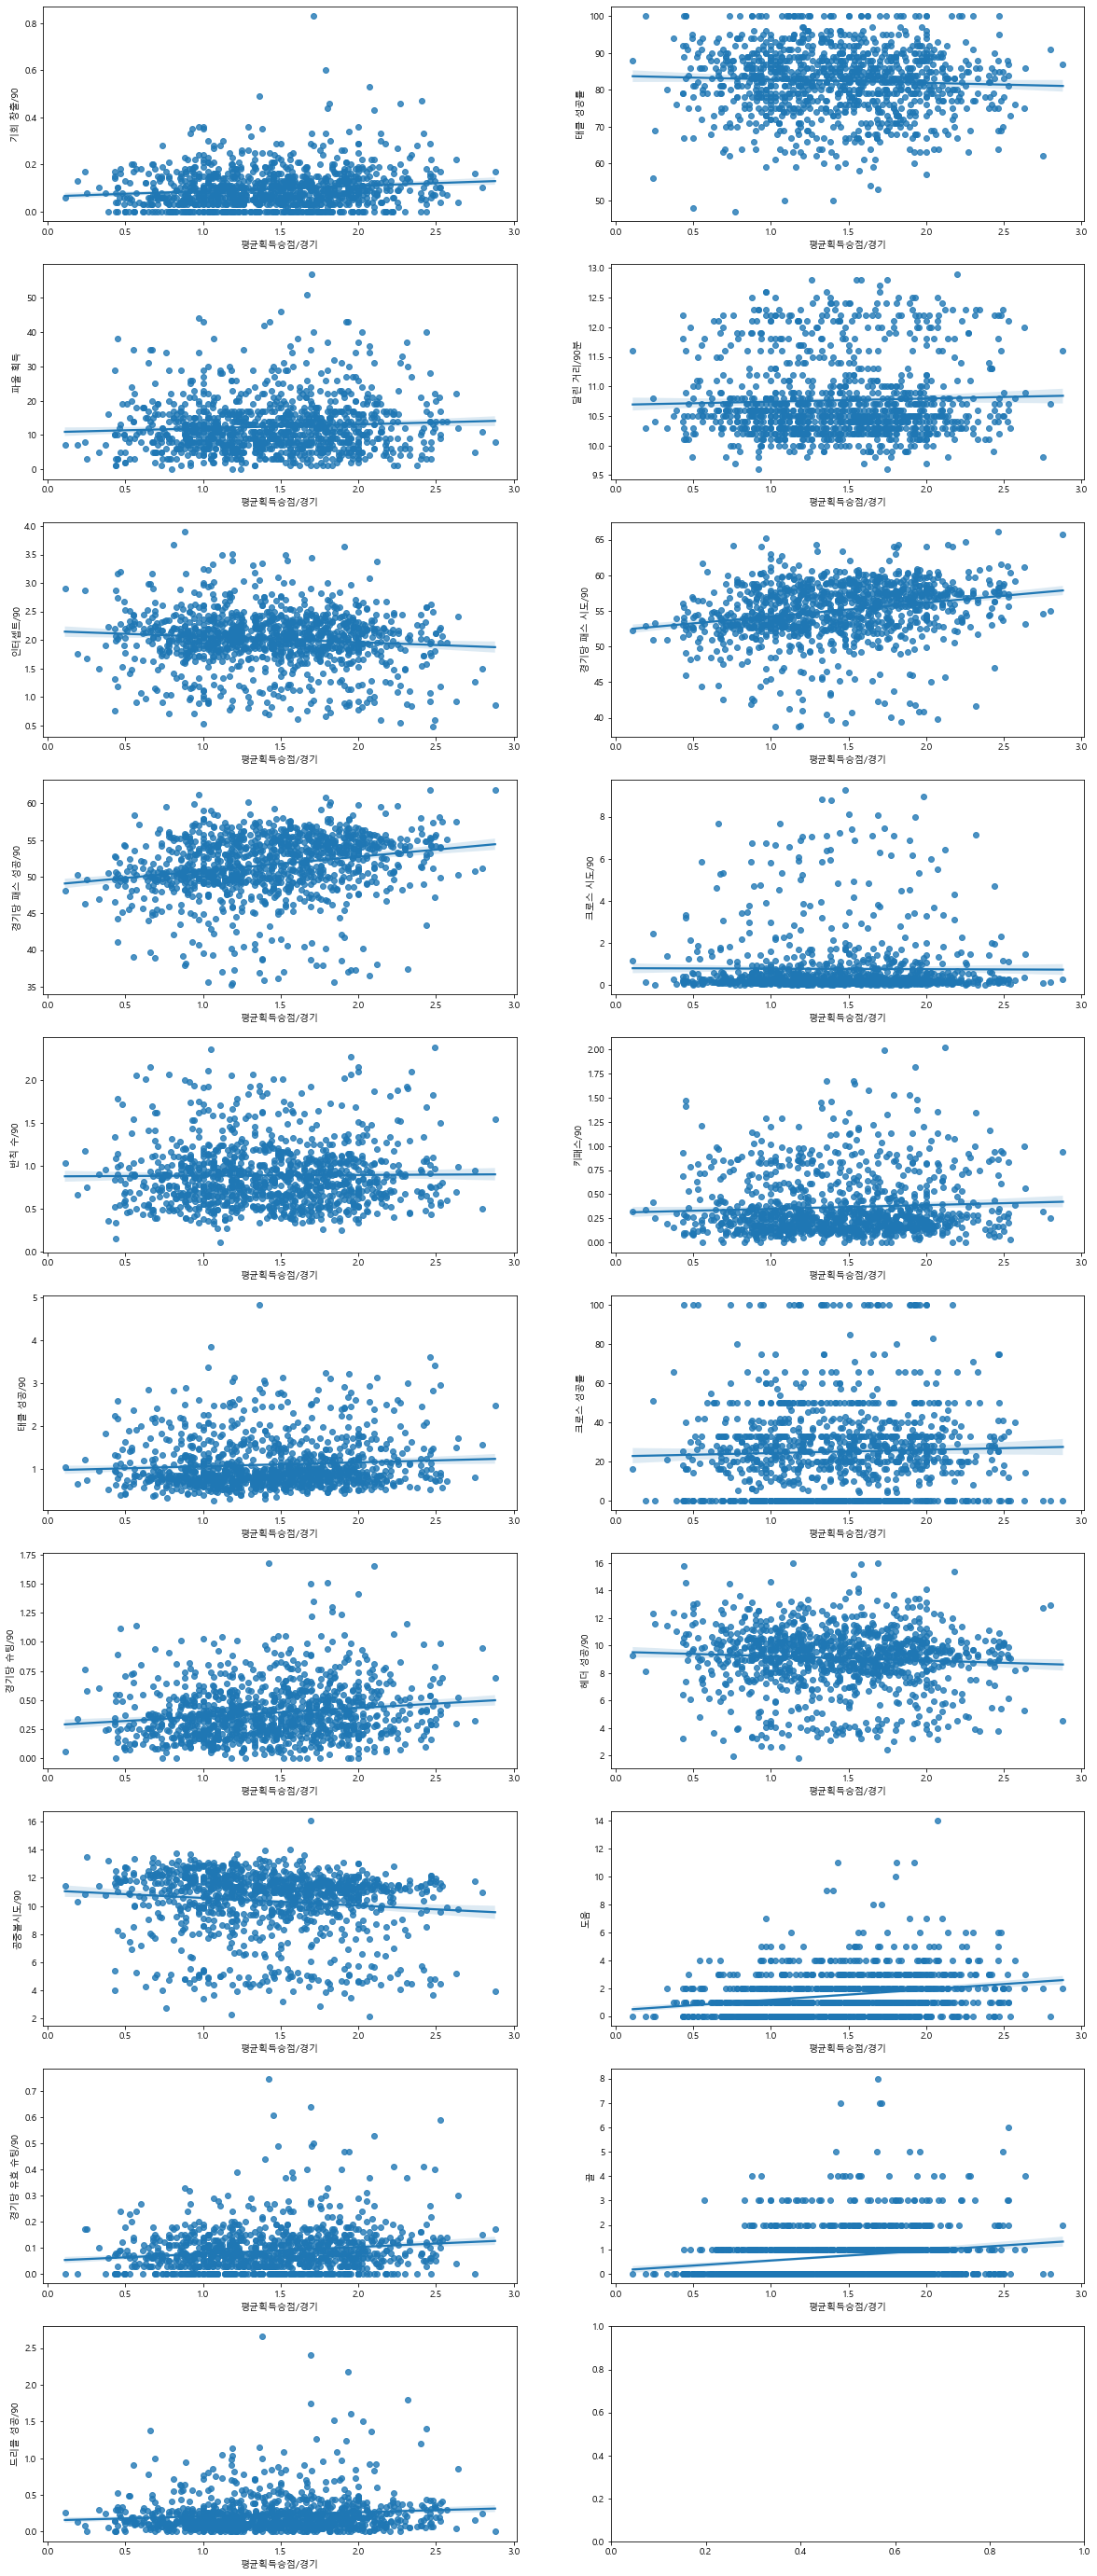

In [7]:
# scatter plot을 이용해서 선형성 검정
# 대부분의 피쳐가 선형성이 없어 보인다.

fig , axes = plt.subplots(10,2,figsize=(20,50))

for i, (ax,feature) in enumerate(zip(axes.ravel(),features)) :
    ax.set_ylabel(feature)
    ax.set_xlabel(target)
    sns.regplot(defender_df.loc[:,target],defender_df.loc[:,feature],ax=ax)
    
plt.show()

In [8]:
# target value와의 correlation을 가지고 선형성 확인

corr = [np.corrcoef(x ,y=defender_df.loc[:,target].T.values)[0][1] for x in defender_df.loc[:,features].T.values]

corr_dict = {}

for i,v in enumerate(corr):
    corr_dict[features[i]] = v

sorted(corr_dict.items(),key = lambda x : x[1],reverse=True)

[('경기당 패스 시도/90', 0.23268705808617635),
 ('도움', 0.23115572706564405),
 ('경기당 패스 성공/90', 0.22161971047692802),
 ('골', 0.192763037254097),
 ('경기당 슈팅/90', 0.1539821100234733),
 ('경기당 유효 슈팅/90', 0.14984543531603808),
 ('기회 창출/90', 0.1341874974737123),
 ('드리블 성공/90', 0.10730006295324789),
 ('태클 성공/90', 0.07745800875323347),
 ('파울 획득', 0.0722186477893574),
 ('키패스/90', 0.06117914929136777),
 ('달린 거리/90분', 0.03886649391487291),
 ('크로스 성공률', 0.03582957331809453),
 ('반칙 수/90', 0.011052330251946022),
 ('크로스 시도/90', -0.00787609352299151),
 ('태클 성공률', -0.05126920081515775),
 ('헤더 성공/90', -0.07026445277875291),
 ('인터셉트/90', -0.09788705778139438),
 ('공중볼시도/90', -0.11417872485585523)]

## 정규성 검정

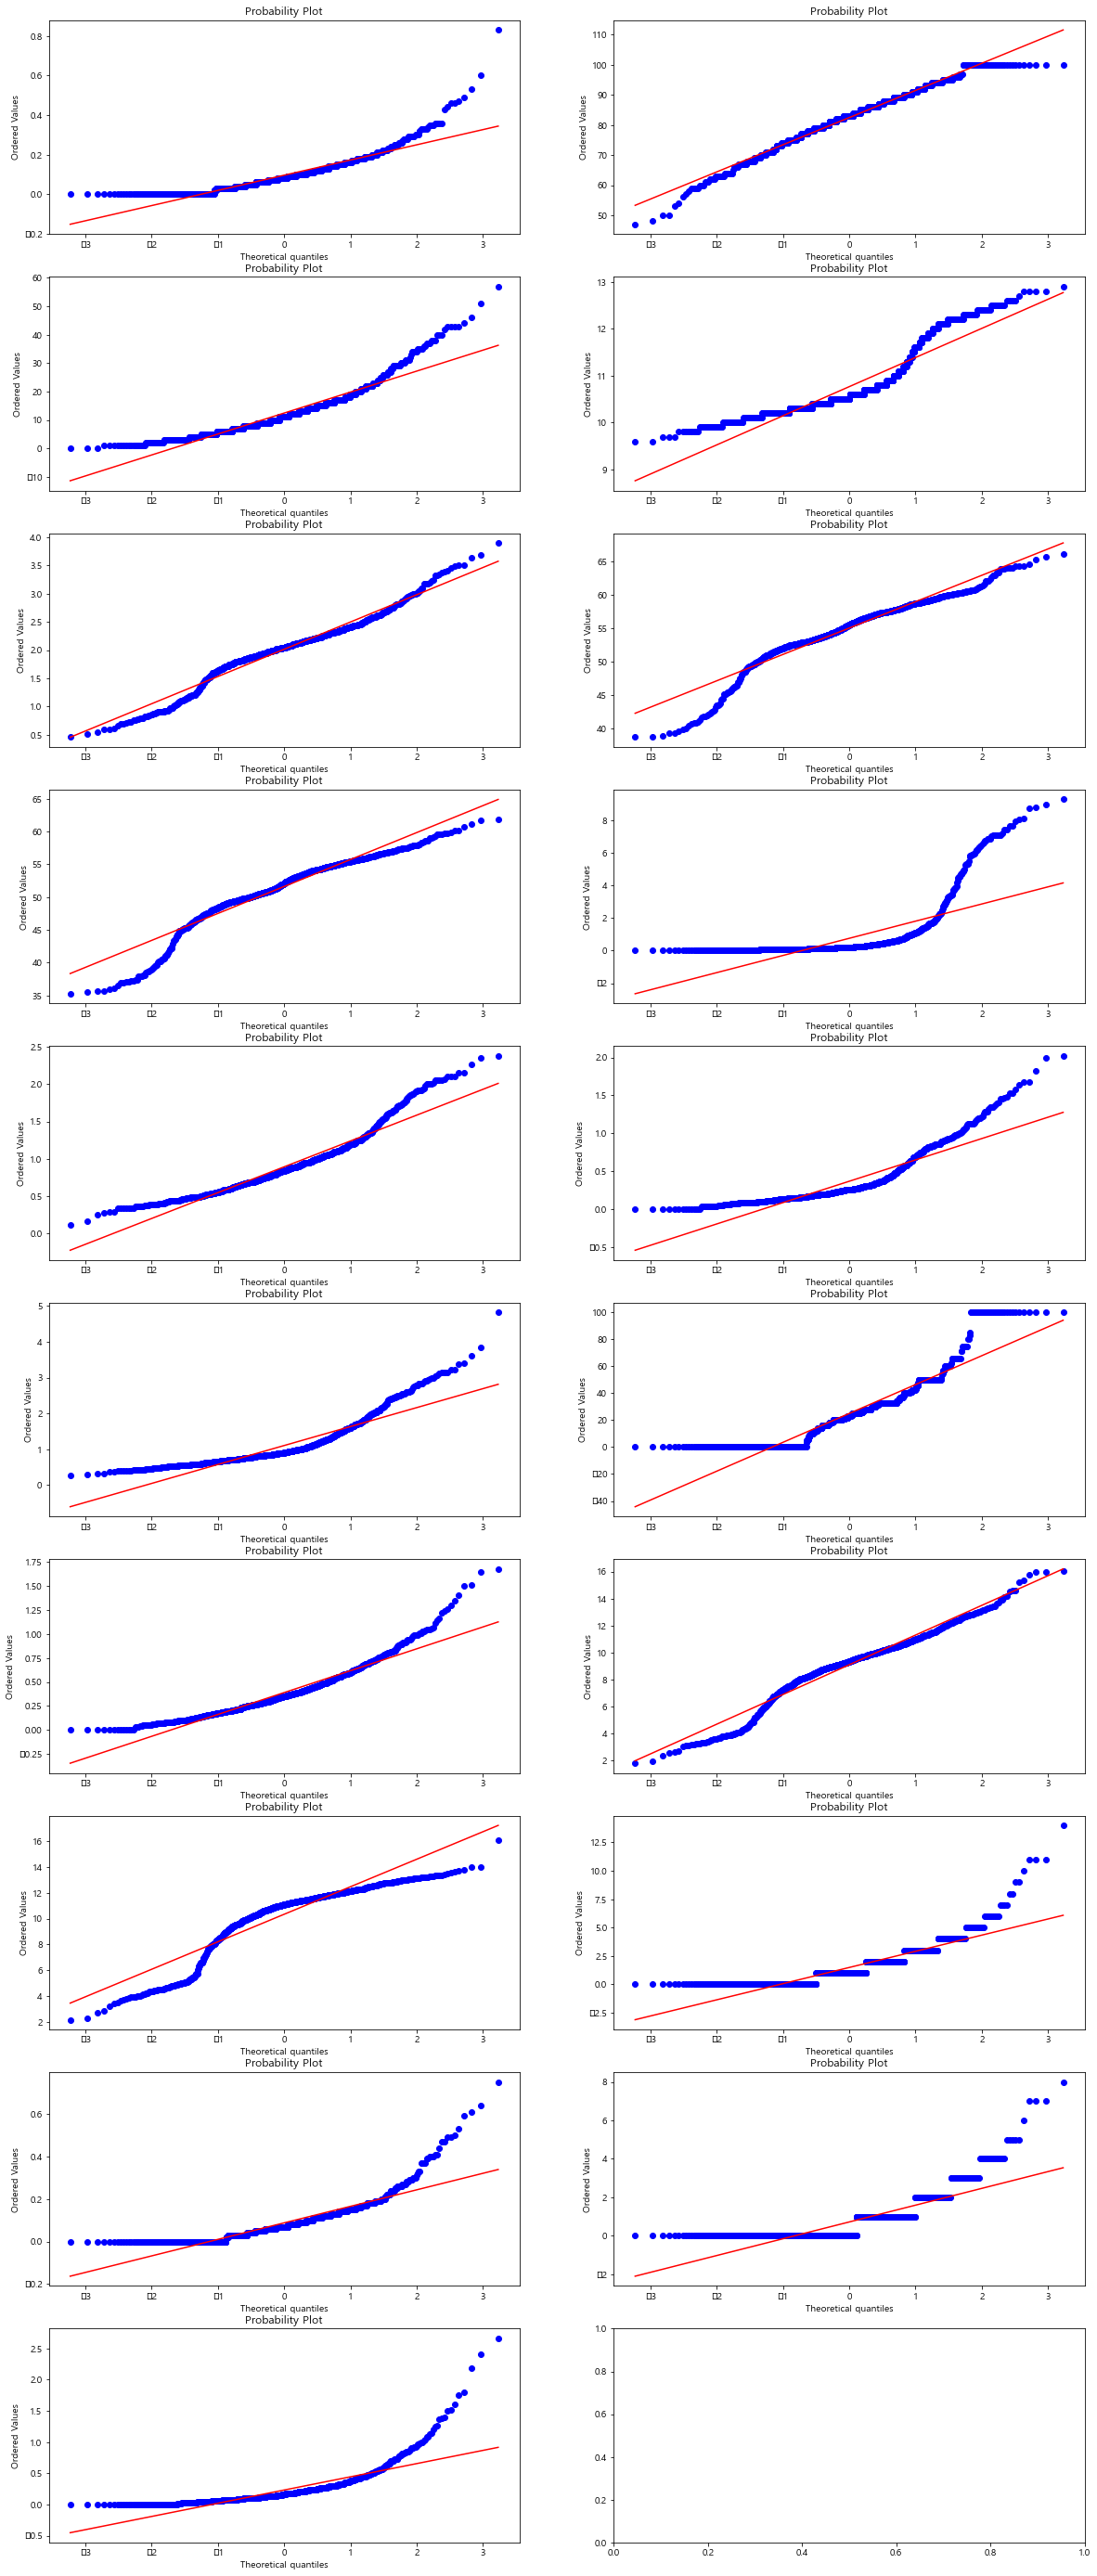

In [10]:
# QQ 플롯을 이용해서 정규성 시각화

fig , axes = plt.subplots(10,2,figsize=(20,50))

for i, (ax,feature) in enumerate(zip(axes.ravel(),features)) :
    ax.set_ylabel(feature)
    ax.set_xlabel(target)
    stats.probplot(defender_df.loc[:,feature],dist='norm',plot=ax)
    
plt.show()

In [11]:
# 모든 변수가 정규성을 만족하지 않는다.

shapiro_dict = {}

for feature in features:
    shapiro_dict[feature] = stats.shapiro(defender_df.loc[:,feature])
      
for k,v in shapiro_dict.items():
    if v[1] > 0.05:
        print(f'{k} 은/는 정규성을 만족한다. {v[1]} \n',)
        
    else:
        print(f'{k} 은/는 정규성을 만족하지 않는다.  {v[1]} \n')

기회 창출/90 은/는 정규성을 만족하지 않는다.  3.955040833228633e-30 

태클 성공률 은/는 정규성을 만족하지 않는다.  6.920378714525555e-10 

파울 획득 은/는 정규성을 만족하지 않는다.  2.0376723997605833e-26 

달린 거리/90분 은/는 정규성을 만족하지 않는다.  4.1552228191962656e-30 

인터셉트/90 은/는 정규성을 만족하지 않는다.  1.2171149826786234e-15 

경기당 패스 시도/90 은/는 정규성을 만족하지 않는다.  5.7937588028418035e-21 

경기당 패스 성공/90 은/는 정규성을 만족하지 않는다.  3.1153995267220906e-22 

크로스 시도/90 은/는 정규성을 만족하지 않는다.  0.0 

반칙 수/90 은/는 정규성을 만족하지 않는다.  8.206022699099534e-23 

키패스/90 은/는 정규성을 만족하지 않는다.  3.4199747694989687e-34 

태클 성공/90 은/는 정규성을 만족하지 않는다.  5.085461864093782e-33 

크로스 성공률 은/는 정규성을 만족하지 않는다.  3.6321215136227177e-29 

경기당 슈팅/90 은/는 정규성을 만족하지 않는다.  1.1259753276991462e-23 

헤더 성공/90 은/는 정규성을 만족하지 않는다.  4.138644008442894e-17 

공중볼시도/90 은/는 정규성을 만족하지 않는다.  3.276787128552764e-31 

도움 은/는 정규성을 만족하지 않는다.  4.5679503843087737e-35 

경기당 유효 슈팅/90 은/는 정규성을 만족하지 않는다.  3.1993996830518975e-34 

골 은/는 정규성을 만족하지 않는다.  9.211435455239185e-41 

드리블 성공/90 은/는 정규성을 만족하지 않는다.  3.043059745127773e-41 



## 등분산성 검정

In [12]:
# 변수간 등분산성을 만족하지 않는다.
stats.levene(*tuple([ tuple(x) for x in defender_df.loc[:,features].values]))

LeveneResult(statistic=0.05669454966751746, pvalue=0.9999999999999999)

## 다중 공선성 확인

In [13]:
this_vif = pd.DataFrame()
this_vif["VIF Factor"] = [vif(defender_df.loc[:,features].values,i) for i in range(defender_df.loc[:,features].values.shape[1])]
this_vif["feautures"] = defender_df.loc[:,features].columns
this_vif = this_vif.sort_values("VIF Factor").reset_index(drop=True)
this_vif

,VIF Factor,feautures
0,2.312913,크로스 성공률
1,2.870784,도움
2,2.947089,골
3,3.385746,기회 창출/90
4,4.360703,드리블 성공/90
5,6.768071,경기당 유효 슈팅/90
6,7.166526,파울 획득
7,8.105876,경기당 슈팅/90
8,8.455682,크로스 시도/90
9,10.464367,키패스/90


## 변수 정규화 및 변수 선택

### 변수 정규화

In [62]:
norm_defender_df = defender_df.copy()

defender_mm = MinMaxScaler().fit(norm_defender_df.loc[:,order_feature])
norm_defender_df.loc[:,order_feature] = defender_mm.transform(norm_defender_df.loc[:,order_feature])

defender_qt = QuantileTransformer(n_quantiles=50,output_distribution='normal').fit(norm_defender_df.loc[:,outlier_features])
norm_defender_df.loc[:,outlier_features] = defender_qt.transform(norm_defender_df.loc[:,outlier_features])

defender_ss = StandardScaler().fit(norm_defender_df.loc[:,nonoutlier_features])
norm_defender_df.loc[:,nonoutlier_features] = defender_ss.transform(norm_defender_df.loc[:,nonoutlier_features])

In [63]:
with open('./models/defender_qt.pickle','wb') as f:
    pickle.dump(defender_qt,f)
    
with open('./models/defender_ss.pickle','wb') as f:
    pickle.dump(defender_ss,f)
    
with open('./models/defender_mm.pickle','wb') as f:
    pickle.dump(defender_mm,f)

In [64]:
outlier_features

['경기당 슈팅/90',
 '기회 창출/90',
 '파울 획득',
 '달린 거리/90분',
 '인터셉트/90',
 '크로스 시도/90',
 '반칙 수/90',
 '키패스/90',
 '경기당 유효 슈팅/90',
 '태클 성공/90',
 '크로스 성공률',
 '드리블 성공/90']

In [65]:
nonoutlier_features

['공중볼시도/90', '태클 성공률', '경기당 패스 성공/90', '경기당 패스 시도/90', '헤더 성공/90']

In [66]:
order_feature

['골', '도움']

### 상관계수와 시각화를 통한 변수 선택

In [67]:
feature_comb = list(combinations(features,2))

In [68]:
'''
fig , axes = plt.subplots(43,4,figsize=(100,860))

for i,(ax,feature) in enumerate(zip(axes.ravel(),feature_comb)):
    sns.scatterplot(x = defender_df.loc[:,feature[0]], y= defender_df.loc[:,feature[1]],ax=ax)
'''

'\nfig , axes = plt.subplots(43,4,figsize=(100,860))\n\nfor i,(ax,feature) in enumerate(zip(axes.ravel(),feature_comb)):\n    sns.scatterplot(x = defender_df.loc[:,feature[0]], y= defender_df.loc[:,feature[1]],ax=ax)\n'

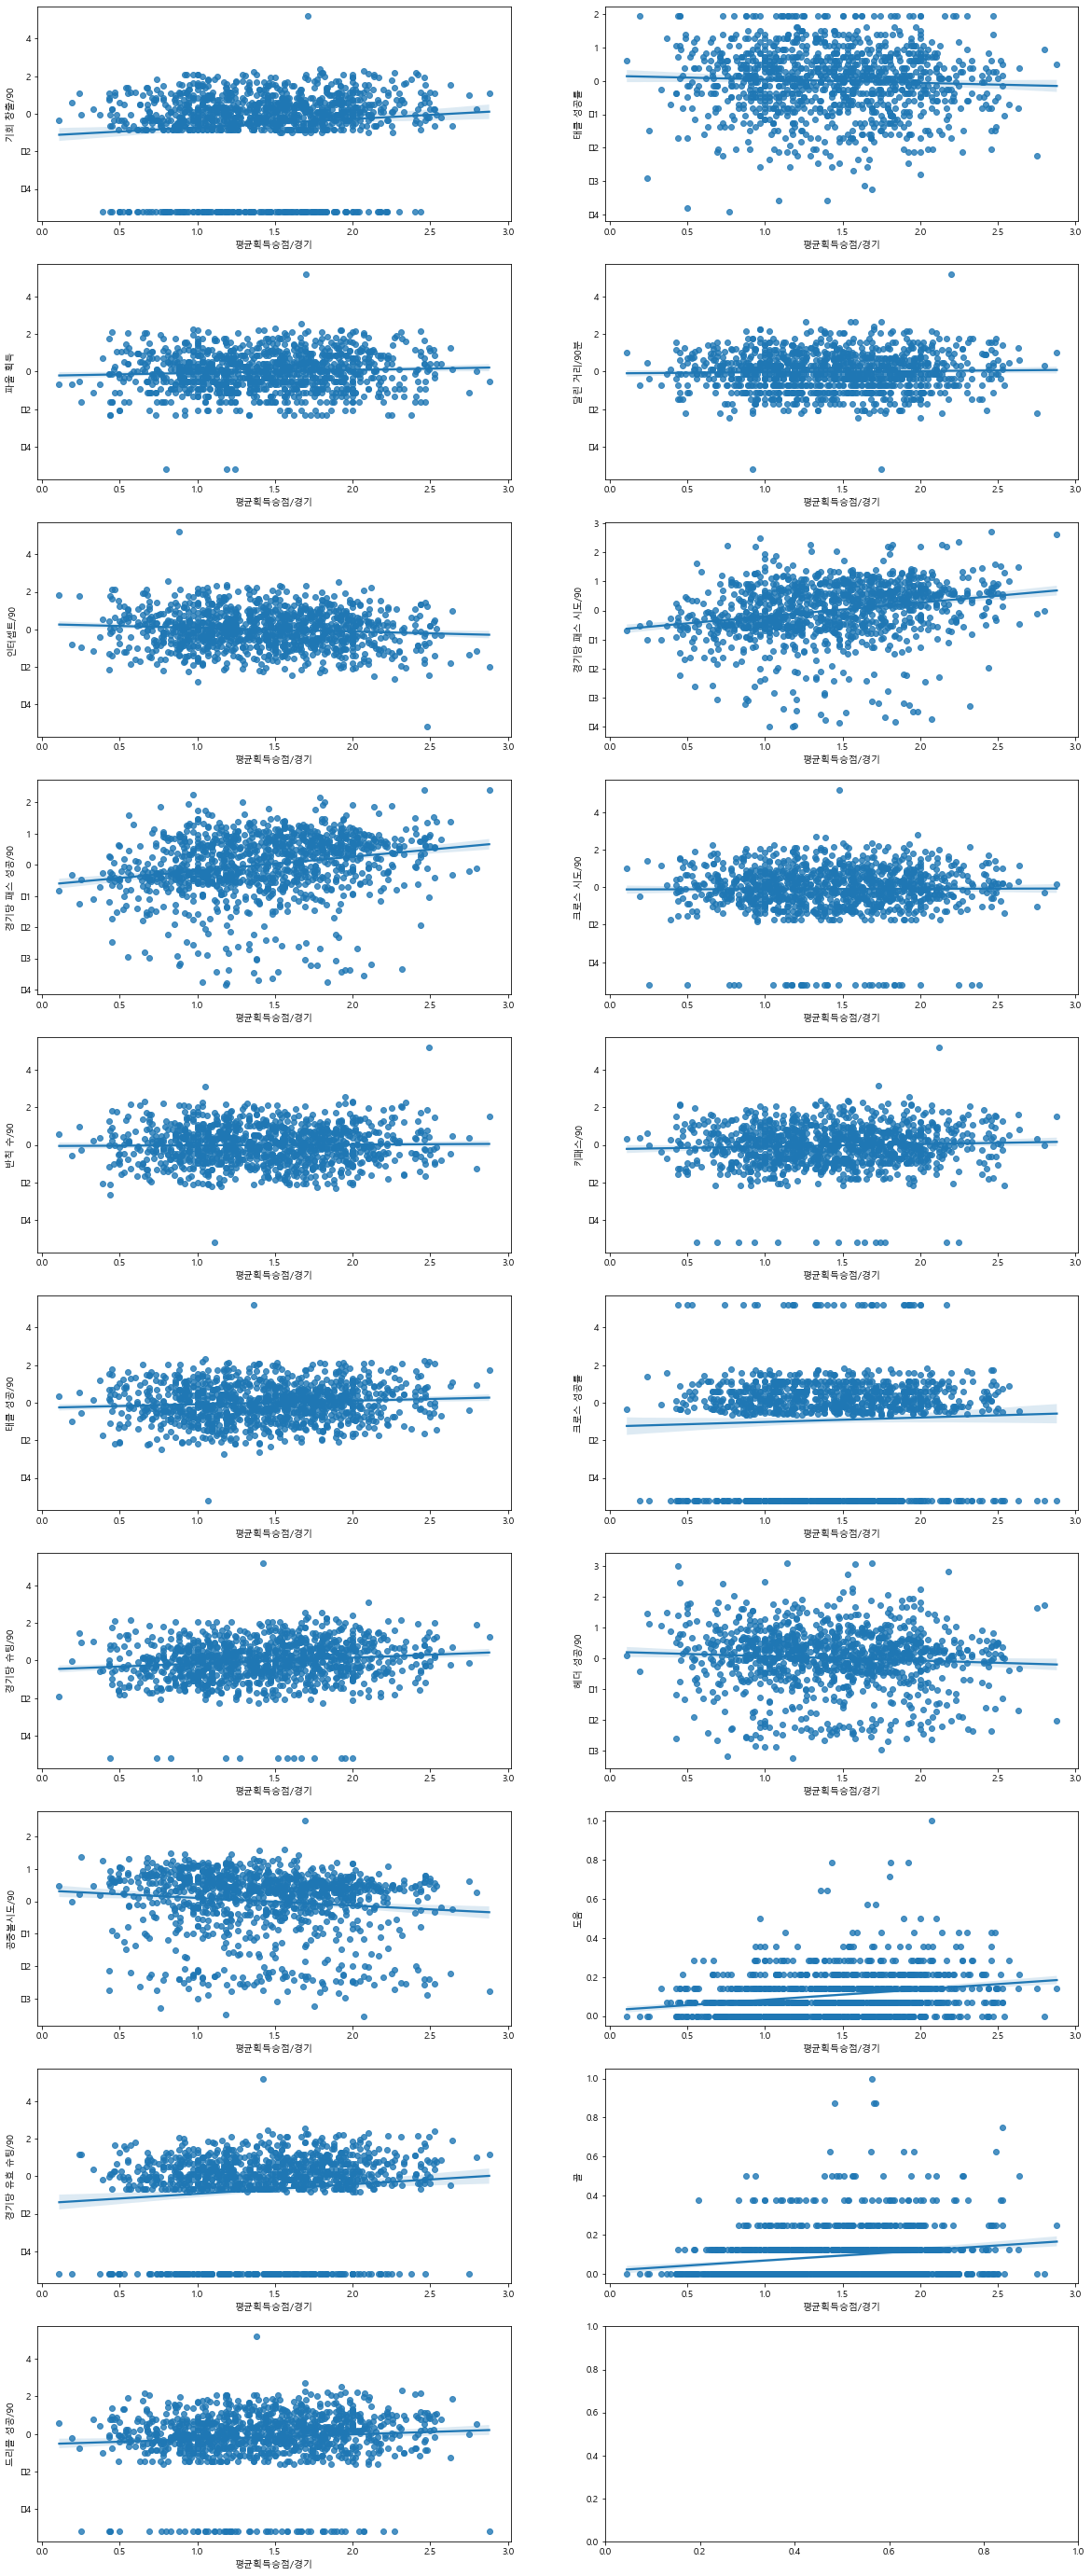

In [69]:
fig , axes = plt.subplots(10,2,figsize=(20,50))

for i, (ax,feature) in enumerate(zip(axes.ravel(),features)) :
    ax.set_ylabel(feature)
    ax.set_xlabel(target)
    sns.regplot(norm_defender_df.loc[:,target],norm_defender_df.loc[:,feature],ax=ax)
    
plt.show()

In [94]:
corr_dict_after_norm = {}

for feature in features:
    corr_dict_after_norm[f'공중볼시도/90/{feature}'] = np.corrcoef(norm_defender_df.loc[:,'공중볼시도/90'],defender_df.loc[:,feature])[0][1]
    
sorted(corr_dict_after_norm.items(),key=lambda x : np.abs(x[1]),reverse=True)

[('공중볼시도/90/공중볼시도/90', 1.0),
 ('공중볼시도/90/헤더 성공/90', 0.8511286136962771),
 ('공중볼시도/90/달린 거리/90분', -0.8137827668548338),
 ('공중볼시도/90/키패스/90', -0.7189130229820017),
 ('공중볼시도/90/태클 성공/90', -0.6742919748051922),
 ('공중볼시도/90/반칙 수/90', -0.5710325696377738),
 ('공중볼시도/90/파울 획득', -0.5054268507820847),
 ('공중볼시도/90/인터셉트/90', 0.4696027582010053),
 ('공중볼시도/90/기회 창출/90', -0.461063853016125),
 ('공중볼시도/90/경기당 유효 슈팅/90', -0.39157158141069215),
 ('공중볼시도/90/도움', -0.3540915419240993),
 ('공중볼시도/90/크로스 시도/90', -0.29906282295471237),
 ('공중볼시도/90/경기당 슈팅/90', -0.2973661138549989),
 ('공중볼시도/90/골', -0.28860880159761026),
 ('공중볼시도/90/드리블 성공/90', -0.20835553348041191),
 ('공중볼시도/90/경기당 패스 성공/90', 0.11841707231831174),
 ('공중볼시도/90/태클 성공률', 0.08023945966097075),
 ('공중볼시도/90/경기당 패스 시도/90', 0.024766282120080484),
 ('공중볼시도/90/크로스 성공률', -0.018982835204055006)]

In [70]:
corr = [np.corrcoef(x ,y=norm_defender_df.loc[:,target].T.values)[0][1] for x in norm_defender_df.loc[:,features].T.values]

corr_dict = {}

for i,v in enumerate(corr):
    corr_dict[features[i]] = v

sorted(corr_dict.items(),key = lambda x : x[1],reverse=True)

[('경기당 패스 시도/90', 0.23268705808617643),
 ('도움', 0.23115572706564416),
 ('경기당 패스 성공/90', 0.22161971047692797),
 ('골', 0.192763037254097),
 ('경기당 슈팅/90', 0.1379188360174621),
 ('경기당 유효 슈팅/90', 0.108690455056979),
 ('기회 창출/90', 0.10500765735699956),
 ('태클 성공/90', 0.09188622190802248),
 ('드리블 성공/90', 0.08664976676886194),
 ('파울 획득', 0.07234417550124776),
 ('키패스/90', 0.05876693435994411),
 ('크로스 성공률', 0.042623192419140116),
 ('달린 거리/90분', 0.03074875053284718),
 ('반칙 수/90', 0.019146667922814997),
 ('크로스 시도/90', 0.006479300211371315),
 ('태클 성공률', -0.051269200815157755),
 ('헤더 성공/90', -0.07026445277875294),
 ('인터셉트/90', -0.0954852314700634),
 ('공중볼시도/90', -0.11417872485585519)]

In [42]:
len(defender_df)

1115

In [95]:
# 상관계수가 높은 변수
# 전진선택법을 위한 변수의 우선순위 순 
good_feature_order = ['경기당 패스 시도/90','경기당 슈팅/90','기회 창출/90','태클 성공/90','드리블 성공/90','파울 획득',
                      '크로스 성공률','태클 성공률','인터셉트/90']

checkpoint_filepath = './tmp/'

defender_mae = []
defender_model = []

for i in range(1,len(good_feature_order)+1):
    
    print(good_feature_order[:i])
    
    fx_train,fx_test,fy_train,fy_test = train_test_split(norm_defender_df.loc[:,good_feature_order[:i]],norm_defender_df.loc[:,target],test_size=0.2)
    
    inputs_layer = Input(shape=(i,))
    hidden1 = Dense(128,activation='swish')(inputs_layer)
    hidden2 = Dense(64,activation='swish')(hidden1)
    hidden3 = Dense(32,activation='swish')(hidden2)
    output = Dense(1,activation='linear')(hidden3)
    model = Model(inputs=[inputs_layer],outputs=[output])
    model.compile(loss='mse',optimizer=Adam(lr=0.001))
    
    
    model.fit(fx_train,fy_train,batch_size=200,epochs=50,validation_data=(fx_test,fy_test))  
    predict_result=model.predict(fx_test)
    mae = mean_absolute_error(fy_test,predict_result)
    defender_mae.append(mae)
    defender_model.append(model)

['경기당 패스 시도/90']
Epoch 1/50
5/5 [==============================] - 0s 34ms/step - loss: 2.2502 - val_loss: 1.9906
Epoch 2/50
5/5 [==============================] - 0s 13ms/step - loss: 2.0461 - val_loss: 1.7905
Epoch 3/50
5/5 [==============================] - 0s 13ms/step - loss: 1.8104 - val_loss: 1.5505
Epoch 4/50
5/5 [==============================] - 0s 15ms/step - loss: 1.5253 - val_loss: 1.2654
Epoch 5/50
5/5 [==============================] - 0s 13ms/step - loss: 1.1942 - val_loss: 0.9548
Epoch 6/50
5/5 [==============================] - 0s 9ms/step - loss: 0.8516 - val_loss: 0.6681
Epoch 7/50
5/5 [==============================] - 0s 7ms/step - loss: 0.5555 - val_loss: 0.4838
Epoch 8/50
5/5 [==============================] - 0s 7ms/step - loss: 0.3892 - val_loss: 0.4181
Epoch 9/50
5/5 [==============================] - 0s 7ms/step - loss: 0.3403 - val_loss: 0.4012
Epoch 10/50
5/5 [==============================] - 0s 7ms/step - loss: 0.3165 - val_loss: 0.3538
Epoch 11/50
5/5 [

5/5 [==============================] - 0s 8ms/step - loss: 0.2151 - val_loss: 0.2160
Epoch 36/50
5/5 [==============================] - 0s 8ms/step - loss: 0.2151 - val_loss: 0.2130
Epoch 37/50
5/5 [==============================] - 0s 8ms/step - loss: 0.2149 - val_loss: 0.2108
Epoch 38/50
5/5 [==============================] - 0s 8ms/step - loss: 0.2154 - val_loss: 0.2112
Epoch 39/50
5/5 [==============================] - 0s 8ms/step - loss: 0.2160 - val_loss: 0.2181
Epoch 40/50
5/5 [==============================] - 0s 8ms/step - loss: 0.2152 - val_loss: 0.2120
Epoch 41/50
5/5 [==============================] - 0s 8ms/step - loss: 0.2156 - val_loss: 0.2119
Epoch 42/50
5/5 [==============================] - 0s 8ms/step - loss: 0.2150 - val_loss: 0.2152
Epoch 43/50
5/5 [==============================] - 0s 8ms/step - loss: 0.2149 - val_loss: 0.2161
Epoch 44/50
5/5 [==============================] - 0s 9ms/step - loss: 0.2153 - val_loss: 0.2103
Epoch 45/50
5/5 [=========================

5/5 [==============================] - 0s 10ms/step - loss: 0.2290 - val_loss: 0.2117
Epoch 19/50
5/5 [==============================] - 0s 10ms/step - loss: 0.2253 - val_loss: 0.2084
Epoch 20/50
5/5 [==============================] - 0s 9ms/step - loss: 0.2225 - val_loss: 0.2049
Epoch 21/50
5/5 [==============================] - 0s 9ms/step - loss: 0.2207 - val_loss: 0.2034
Epoch 22/50
5/5 [==============================] - 0s 9ms/step - loss: 0.2192 - val_loss: 0.2037
Epoch 23/50
5/5 [==============================] - 0s 9ms/step - loss: 0.2187 - val_loss: 0.2014
Epoch 24/50
5/5 [==============================] - 0s 9ms/step - loss: 0.2169 - val_loss: 0.1995
Epoch 25/50
5/5 [==============================] - 0s 9ms/step - loss: 0.2170 - val_loss: 0.2012
Epoch 26/50
5/5 [==============================] - 0s 9ms/step - loss: 0.2152 - val_loss: 0.2007
Epoch 27/50
5/5 [==============================] - 0s 9ms/step - loss: 0.2147 - val_loss: 0.2001
Epoch 28/50
5/5 [=======================

Epoch 1/50
5/5 [==============================] - 0s 31ms/step - loss: 2.1685 - val_loss: 1.9421
Epoch 2/50
5/5 [==============================] - 0s 9ms/step - loss: 1.7902 - val_loss: 1.6254
Epoch 3/50
5/5 [==============================] - 0s 9ms/step - loss: 1.4926 - val_loss: 1.3442
Epoch 4/50
5/5 [==============================] - 0s 9ms/step - loss: 1.2316 - val_loss: 1.0793
Epoch 5/50
5/5 [==============================] - 0s 9ms/step - loss: 0.9669 - val_loss: 0.8378
Epoch 6/50
5/5 [==============================] - 0s 9ms/step - loss: 0.7135 - val_loss: 0.6509
Epoch 7/50
5/5 [==============================] - 0s 10ms/step - loss: 0.5367 - val_loss: 0.5210
Epoch 8/50
5/5 [==============================] - 0s 9ms/step - loss: 0.4360 - val_loss: 0.4528
Epoch 9/50
5/5 [==============================] - 0s 9ms/step - loss: 0.3955 - val_loss: 0.4217
Epoch 10/50
5/5 [==============================] - 0s 10ms/step - loss: 0.3586 - val_loss: 0.3909
Epoch 11/50
5/5 [===================

5/5 [==============================] - 0s 9ms/step - loss: 0.1916 - val_loss: 0.2050
Epoch 35/50
5/5 [==============================] - 0s 9ms/step - loss: 0.1914 - val_loss: 0.2019
Epoch 36/50
5/5 [==============================] - 0s 9ms/step - loss: 0.1897 - val_loss: 0.2020
Epoch 37/50
5/5 [==============================] - 0s 8ms/step - loss: 0.1906 - val_loss: 0.2027
Epoch 38/50
5/5 [==============================] - 0s 9ms/step - loss: 0.1909 - val_loss: 0.2052
Epoch 39/50
5/5 [==============================] - 0s 8ms/step - loss: 0.1888 - val_loss: 0.2029
Epoch 40/50
5/5 [==============================] - 0s 9ms/step - loss: 0.1893 - val_loss: 0.2037
Epoch 41/50
5/5 [==============================] - 0s 9ms/step - loss: 0.1876 - val_loss: 0.2046
Epoch 42/50
5/5 [==============================] - 0s 9ms/step - loss: 0.1882 - val_loss: 0.2043
Epoch 43/50
5/5 [==============================] - 0s 8ms/step - loss: 0.1885 - val_loss: 0.2050
Epoch 44/50
5/5 [=========================

5/5 [==============================] - 0s 9ms/step - loss: 0.2511 - val_loss: 0.2240
Epoch 17/50
5/5 [==============================] - 0s 10ms/step - loss: 0.2407 - val_loss: 0.2152
Epoch 18/50
5/5 [==============================] - 0s 10ms/step - loss: 0.2311 - val_loss: 0.2106
Epoch 19/50
5/5 [==============================] - 0s 9ms/step - loss: 0.2242 - val_loss: 0.2055
Epoch 20/50
5/5 [==============================] - 0s 10ms/step - loss: 0.2182 - val_loss: 0.2009
Epoch 21/50
5/5 [==============================] - 0s 9ms/step - loss: 0.2141 - val_loss: 0.1974
Epoch 22/50
5/5 [==============================] - 0s 10ms/step - loss: 0.2100 - val_loss: 0.1952
Epoch 23/50
5/5 [==============================] - 0s 10ms/step - loss: 0.2076 - val_loss: 0.1955
Epoch 24/50
5/5 [==============================] - 0s 8ms/step - loss: 0.2048 - val_loss: 0.1948
Epoch 25/50
5/5 [==============================] - 0s 9ms/step - loss: 0.2031 - val_loss: 0.1953
Epoch 26/50
5/5 [====================

In [96]:
defender_mae

[0.41007542960846904,
 0.3783484715731154,
 0.41126602303286836,
 0.3628628462098639,
 0.37423560599040556,
 0.393537447912276,
 0.37050739624040546,
 0.4262933702746849,
 0.3563864040802412]

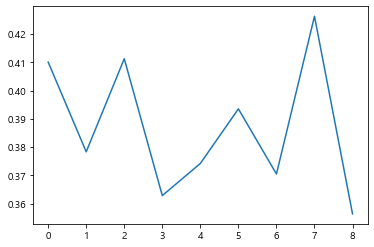

In [97]:
plt.plot(defender_mae)
plt.show()

In [107]:
good_features = good_feature_order[0:np.argmin(np.array(defender_mae))+1]

In [113]:
good_features

['경기당 패스 시도/90',
 '경기당 슈팅/90',
 '기회 창출/90',
 '태클 성공/90',
 '드리블 성공/90',
 '파울 획득',
 '크로스 성공률',
 '태클 성공률',
 '인터셉트/90']

In [108]:
fx_train,fx_test,fy_train,fy_test = train_test_split(norm_defender_df.loc[:,good_features],norm_defender_df.loc[:,target],test_size=0.2)

In [112]:
inputs_layer = Input(shape=(len(good_features),))
hidden1 = Dense(256,activation='swish')(inputs_layer)
hidden2 = Dense(512,activation='swish',kernel_regularizer=L2(l2=0.01))(hidden1)
hidden3 = Dropout(0.1)(hidden2)
hidden4 = Dense(1024,activation='swish',kernel_regularizer=L2(l2=0.01))(hidden3)
hidden5 = Dense(2048,activation='swish',kernel_regularizer=L2(l2=0.01))(hidden4)
hidden6 = Dropout(0.2)(hidden5)
hidden7 = Dense(1024,activation='swish')(hidden6)
hidden8 = Dense(512,activation='swish')(hidden7)
hidden9 = Dense(256,activation='swish')(hidden8)
hidden10 = Dense(128,activation='swish')(hidden9)
hidden11 = Dense(4,activation='swish')(hidden10)
output = Dense(1,activation='linear')(hidden11)
model = Model(inputs=[inputs_layer],outputs=[output])
model.compile(loss='mse',optimizer=Adam(lr=0.0005)) 
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=100)
model.fit(fx_train,fy_train,batch_size=100,epochs=600,validation_data=(fx_test,fy_test))  
predict_result=model.predict(fx_test)
mae = mean_absolute_error(fy_test,predict_result)
print(mae)
#model.save('./models/defender_nn.h5')

Epoch 1/600
9/9 [==============================] - 1s 47ms/step - loss: 23.1928 - val_loss: 19.1882
Epoch 2/600
9/9 [==============================] - 0s 13ms/step - loss: 17.1048 - val_loss: 14.7740
Epoch 3/600
9/9 [==============================] - 0s 12ms/step - loss: 13.2757 - val_loss: 11.4879
Epoch 4/600
9/9 [==============================] - 0s 12ms/step - loss: 10.2626 - val_loss: 8.8350
Epoch 5/600
9/9 [==============================] - 0s 13ms/step - loss: 7.8846 - val_loss: 6.7825
Epoch 6/600
9/9 [==============================] - 0s 12ms/step - loss: 6.0615 - val_loss: 5.2243
Epoch 7/600
9/9 [==============================] - 0s 12ms/step - loss: 4.6771 - val_loss: 4.0427
Epoch 8/600
9/9 [==============================] - 0s 12ms/step - loss: 3.6321 - val_loss: 3.1526
Epoch 9/600
9/9 [==============================] - 0s 12ms/step - loss: 2.8459 - val_loss: 2.4909
Epoch 10/600
9/9 [==============================] - 0s 11ms/step - loss: 2.2536 - val_loss: 1.9807
Epoch 11/600

Epoch 84/600
9/9 [==============================] - 0s 12ms/step - loss: 0.2071 - val_loss: 0.2123
Epoch 85/600
9/9 [==============================] - 0s 12ms/step - loss: 0.2099 - val_loss: 0.2123
Epoch 86/600
9/9 [==============================] - 0s 12ms/step - loss: 0.2096 - val_loss: 0.2154
Epoch 87/600
9/9 [==============================] - 0s 11ms/step - loss: 0.2052 - val_loss: 0.2159
Epoch 88/600
9/9 [==============================] - 0s 12ms/step - loss: 0.2075 - val_loss: 0.2144
Epoch 89/600
9/9 [==============================] - 0s 12ms/step - loss: 0.2088 - val_loss: 0.2231
Epoch 90/600
9/9 [==============================] - 0s 11ms/step - loss: 0.2164 - val_loss: 0.2388
Epoch 91/600
9/9 [==============================] - 0s 12ms/step - loss: 0.2077 - val_loss: 0.2169
Epoch 92/600
9/9 [==============================] - 0s 12ms/step - loss: 0.2103 - val_loss: 0.2162
Epoch 93/600
9/9 [==============================] - 0s 12ms/step - loss: 0.2129 - val_loss: 0.2118
Epoch 94/6

9/9 [==============================] - 0s 12ms/step - loss: 0.2056 - val_loss: 0.2219
Epoch 167/600
9/9 [==============================] - 0s 12ms/step - loss: 0.2195 - val_loss: 0.2139
Epoch 168/600
9/9 [==============================] - 0s 12ms/step - loss: 0.2130 - val_loss: 0.2145
Epoch 169/600
9/9 [==============================] - 0s 12ms/step - loss: 0.2053 - val_loss: 0.2187
Epoch 170/600
9/9 [==============================] - 0s 12ms/step - loss: 0.2027 - val_loss: 0.2287
Epoch 171/600
9/9 [==============================] - 0s 12ms/step - loss: 0.2126 - val_loss: 0.2135
Epoch 172/600
9/9 [==============================] - 0s 12ms/step - loss: 0.2011 - val_loss: 0.2162
Epoch 173/600
9/9 [==============================] - 0s 12ms/step - loss: 0.2000 - val_loss: 0.2110
Epoch 174/600
9/9 [==============================] - 0s 12ms/step - loss: 0.2004 - val_loss: 0.2087
Epoch 175/600
9/9 [==============================] - 0s 12ms/step - loss: 0.1983 - val_loss: 0.2143
Epoch 176/600


9/9 [==============================] - 0s 12ms/step - loss: 0.1964 - val_loss: 0.2129
Epoch 249/600
9/9 [==============================] - 0s 12ms/step - loss: 0.1963 - val_loss: 0.2146
Epoch 250/600
9/9 [==============================] - 0s 12ms/step - loss: 0.2009 - val_loss: 0.2132
Epoch 251/600
9/9 [==============================] - 0s 12ms/step - loss: 0.1965 - val_loss: 0.2168
Epoch 252/600
9/9 [==============================] - 0s 11ms/step - loss: 0.1977 - val_loss: 0.2116
Epoch 253/600
9/9 [==============================] - 0s 12ms/step - loss: 0.1960 - val_loss: 0.2080
Epoch 254/600
9/9 [==============================] - 0s 12ms/step - loss: 0.1941 - val_loss: 0.2141
Epoch 255/600
9/9 [==============================] - 0s 12ms/step - loss: 0.1953 - val_loss: 0.2143
Epoch 256/600
9/9 [==============================] - 0s 12ms/step - loss: 0.1986 - val_loss: 0.2144
Epoch 257/600
9/9 [==============================] - 0s 12ms/step - loss: 0.2098 - val_loss: 0.2177
Epoch 258/600


9/9 [==============================] - 0s 12ms/step - loss: 0.1969 - val_loss: 0.2147
Epoch 331/600
9/9 [==============================] - 0s 12ms/step - loss: 0.1945 - val_loss: 0.2118
Epoch 332/600
9/9 [==============================] - 0s 12ms/step - loss: 0.1943 - val_loss: 0.2139
Epoch 333/600
9/9 [==============================] - 0s 12ms/step - loss: 0.1934 - val_loss: 0.2108
Epoch 334/600
9/9 [==============================] - 0s 12ms/step - loss: 0.1921 - val_loss: 0.2110
Epoch 335/600
9/9 [==============================] - 0s 12ms/step - loss: 0.1959 - val_loss: 0.2091
Epoch 336/600
9/9 [==============================] - 0s 12ms/step - loss: 0.1939 - val_loss: 0.2117
Epoch 337/600
9/9 [==============================] - 0s 12ms/step - loss: 0.1938 - val_loss: 0.2146
Epoch 338/600
9/9 [==============================] - 0s 12ms/step - loss: 0.1986 - val_loss: 0.2104
Epoch 339/600
9/9 [==============================] - 0s 12ms/step - loss: 0.1964 - val_loss: 0.2092
Epoch 340/600


9/9 [==============================] - 0s 12ms/step - loss: 0.1929 - val_loss: 0.2134
Epoch 413/600
9/9 [==============================] - 0s 12ms/step - loss: 0.1919 - val_loss: 0.2151
Epoch 414/600
9/9 [==============================] - 0s 12ms/step - loss: 0.1956 - val_loss: 0.2118
Epoch 415/600
9/9 [==============================] - 0s 12ms/step - loss: 0.1918 - val_loss: 0.2144
Epoch 416/600
9/9 [==============================] - 0s 12ms/step - loss: 0.1934 - val_loss: 0.2167
Epoch 417/600
9/9 [==============================] - 0s 12ms/step - loss: 0.1945 - val_loss: 0.2150
Epoch 418/600
9/9 [==============================] - 0s 12ms/step - loss: 0.1970 - val_loss: 0.2147
Epoch 419/600
9/9 [==============================] - 0s 12ms/step - loss: 0.1914 - val_loss: 0.2178
Epoch 420/600
9/9 [==============================] - 0s 12ms/step - loss: 0.1921 - val_loss: 0.2115
Epoch 421/600
9/9 [==============================] - 0s 12ms/step - loss: 0.1910 - val_loss: 0.2164
Epoch 422/600


9/9 [==============================] - 0s 12ms/step - loss: 0.1880 - val_loss: 0.2142
Epoch 495/600
9/9 [==============================] - 0s 12ms/step - loss: 0.1890 - val_loss: 0.2226
Epoch 496/600
9/9 [==============================] - 0s 12ms/step - loss: 0.1928 - val_loss: 0.2132
Epoch 497/600
9/9 [==============================] - 0s 12ms/step - loss: 0.1896 - val_loss: 0.2144
Epoch 498/600
9/9 [==============================] - 0s 12ms/step - loss: 0.1893 - val_loss: 0.2140
Epoch 499/600
9/9 [==============================] - 0s 12ms/step - loss: 0.1939 - val_loss: 0.2167
Epoch 500/600
9/9 [==============================] - 0s 12ms/step - loss: 0.1935 - val_loss: 0.2188
Epoch 501/600
9/9 [==============================] - 0s 12ms/step - loss: 0.1900 - val_loss: 0.2198
Epoch 502/600
9/9 [==============================] - 0s 12ms/step - loss: 0.1929 - val_loss: 0.2110
Epoch 503/600
9/9 [==============================] - 0s 12ms/step - loss: 0.1983 - val_loss: 0.2201
Epoch 504/600


9/9 [==============================] - 0s 12ms/step - loss: 0.1842 - val_loss: 0.2168
Epoch 577/600
9/9 [==============================] - 0s 12ms/step - loss: 0.1834 - val_loss: 0.2150
Epoch 578/600
9/9 [==============================] - 0s 12ms/step - loss: 0.1859 - val_loss: 0.2162
Epoch 579/600
9/9 [==============================] - 0s 12ms/step - loss: 0.1865 - val_loss: 0.2195
Epoch 580/600
9/9 [==============================] - 0s 12ms/step - loss: 0.1850 - val_loss: 0.2118
Epoch 581/600
9/9 [==============================] - 0s 12ms/step - loss: 0.1846 - val_loss: 0.2170
Epoch 582/600
9/9 [==============================] - 0s 12ms/step - loss: 0.1876 - val_loss: 0.2126
Epoch 583/600
9/9 [==============================] - 0s 12ms/step - loss: 0.1863 - val_loss: 0.2166
Epoch 584/600
9/9 [==============================] - 0s 12ms/step - loss: 0.1927 - val_loss: 0.2178
Epoch 585/600
9/9 [==============================] - 0s 12ms/step - loss: 0.1917 - val_loss: 0.2184
Epoch 586/600
